# Classify Penguins with Logistic Regression

In [1]:
import pandas as pd 
import numpy as np
import arviz as az
import pymc as pm
import palmerpenguins as pp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Load Data

In [2]:
penguins = pp.load_penguins()

In [3]:
missing_data = penguins.isnull()[["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]].any(axis=1)
penguins = penguins.loc[~missing_data]

In [22]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

In [33]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])

### Model using Bill Length as Covariate

In [60]:
with pm.Model() as model_logistic_penguins_bill_length:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)

    mu = beta_0 + pm.math.dot(bill_length_obs, beta_1)

    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))

    bd = pm.Deterministic("bd", -beta_0/beta_1)

    yl = pm.Bernoulli("yl", p=theta, observed=species.codes)

    idata = pm.sample_prior_predictive(samples= 10000)

Sampling: [beta_0, beta_1, yl]


In [63]:
with model_logistic_penguins_bill_length:
  idata.extend(pm.sample(5000, chains= 2, random_seed= 42))
  pm.sample_posterior_predictive(idata, extend_inferencedata= True, random_seed= 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_0, beta_1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [yl]


In [73]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

[Text(0, 0, 'Adelie'), Text(1, 0, 'Chinstrap')]

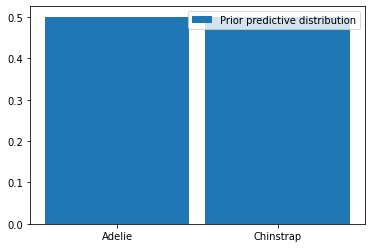

In [65]:
ax = az.plot_dist(idata.prior_predictive.yl, label="Prior predictive distribution")
ax.set_xticklabels(["Adelie", "Chinstrap"])

In [67]:
az.summary(idata, var_names=["beta_0", "beta_1", "bd"], round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
beta_0,-34.52,4.42,-42.75,-26.75
beta_1,0.78,0.10,0.60,0.97
bd,44.24,0.41,43.48,45.02


array([[<AxesSubplot:title={'center':'beta_0'}>,
        <AxesSubplot:title={'center':'beta_0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'beta_1'}>,
        <AxesSubplot:title={'center':'beta_1'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

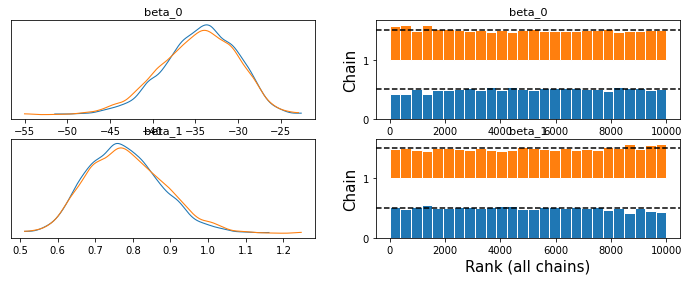

In [72]:
az.plot_trace(idata, var_names=["beta_0", "beta_1"], kind= "rank_bars", compact= False)

### Model using Mass as Covariate

In [74]:
mass_obs = penguins.loc[species_filter, "body_mass_g"].values

with pm.Model() as model_logistic_penguins_mass:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)

    mu = beta_0 + pm.math.dot(mass_obs, beta_1)
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    bd = pm.Deterministic("bd", -beta_0/beta_1)

    yl = pm.Bernoulli("yl", p=theta, observed=species.codes)

    idata_mass = pm.sample(5000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 49 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 10000 divergences after tuning. Increase `target_accept` or reparameterize.


In [85]:
with model_logistic_penguins_mass:
    pm.sample_posterior_predictive(idata_mass,extend_inferencedata= True,random_seed=42)

Sampling: [yl]


In [75]:
az.summary(idata_mass, var_names=["beta_0", "beta_1", "bd"], round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
beta_0,-0.70,1.08,-3.27,0.64
beta_1,0.14,0.22,-0.00,0.51
bd,5723.07,657316.82,-8754.79,19336.26


### Model using Bill length & Mass as Covariates

In [76]:
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

X.insert(0,"Intercept", value=1)
X = X.values

with pm.Model() as model_logistic_penguins_bill_length_mass:
    beta = pm.Normal("beta", mu=0, sigma=20, shape=3)

    mu = pm.math.dot(X, beta)

    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    bd = pm.Deterministic("bd", -beta[0]/beta[2] - beta[1]/beta[2] * X[:,1])

    yl = pm.Bernoulli("yl", p=theta, observed=species.codes)

    idata_bill_mass = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1292 divergences after tuning. Increase `target_accept` or reparameterize.


In [84]:
with model_logistic_penguins_bill_length_mass:
    pm.sample_posterior_predictive(idata_bill_mass, random_seed=42, extend_inferencedata= True)

Sampling: [yl]


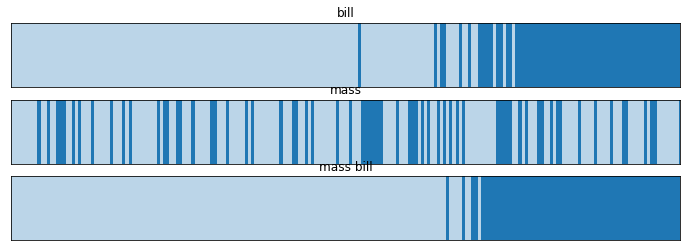

In [89]:
import matplotlib.pyplot as plt

models = {"bill": idata, "mass": idata_mass, "mass bill": idata_bill_mass}

_, axes = plt.subplots(3, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "yl", ax=ax)
    ax.set_title(label)